### CS 178: Machine Learning &amp; Data Mining

# Discussion 08

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.inspection import DecisionBoundaryDisplay

plt.set_cmap('nipy_spectral');

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)

<Figure size 432x288 with 0 Axes>

# K-Means Clustering

Let's start with a simple toy data set, and see how to build a clustering:

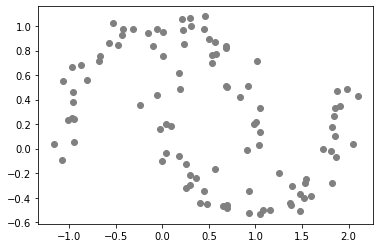

In [2]:
# Creating 2-moons dataset
n_samples = 100
noise = 0.1
X, _ = make_moons(n_samples, noise=noise)

fig, axes = plt.subplots()
axes.scatter(X[:,0], X[:,1], c=[(.5,.5,.5)]);

### Running K-Means

Let's walk through an execution of k-means manually.  A lot of this can be handled internally by scikit, but we'll do it step by step so we can see how it runs.

In [9]:
clust = KMeans(n_clusters=6, init='random', n_init=1, random_state=seed)

In [4]:
KMeans?

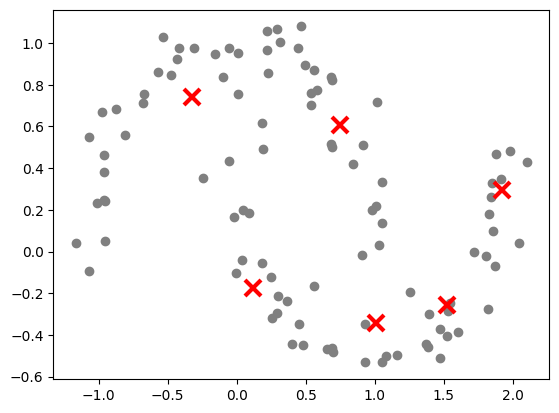

In [10]:
clust.max_iter = 1
clust.fit(X)

fig, axes = plt.subplots()
axes.scatter(X[:,0], X[:,1], c=[(.5,.5,.5)]);
axes.plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3);

and we can look at the cluster assignments, which are stored internally or accessible by calling ``predict`` to find the closest cluster to any given set of points:

In [11]:
clust.predict(X)

array([0, 0, 4, 5, 2, 5, 4, 0, 0, 0, 0, 5, 5, 2, 5, 4, 2, 1, 1, 4, 3, 0,
       0, 4, 1, 1, 5, 5, 4, 0, 3, 5, 3, 2, 5, 1, 0, 3, 5, 1, 0, 3, 1, 4,
       3, 3, 0, 3, 0, 3, 0, 3, 0, 5, 4, 0, 2, 3, 4, 0, 0, 3, 2, 3, 0, 0,
       5, 3, 5, 3, 3, 1, 3, 1, 3, 5, 2, 0, 0, 2, 3, 2, 1, 4, 1, 5, 2, 2,
       0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 4, 0], dtype=int32)

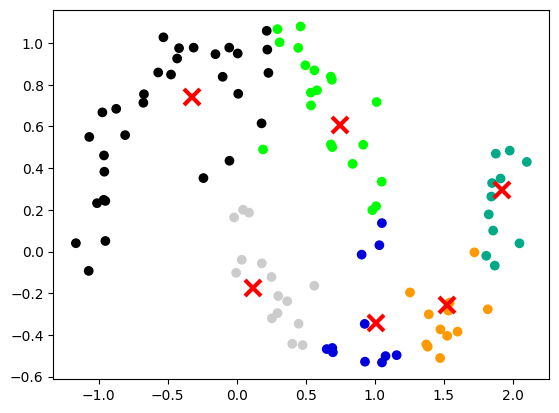

In [12]:
fig, axes = plt.subplots()
axes.scatter(X[:,0], X[:,1], c=clust.predict(X));
axes.plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3);

We can step through iterations of the algorithm manually:

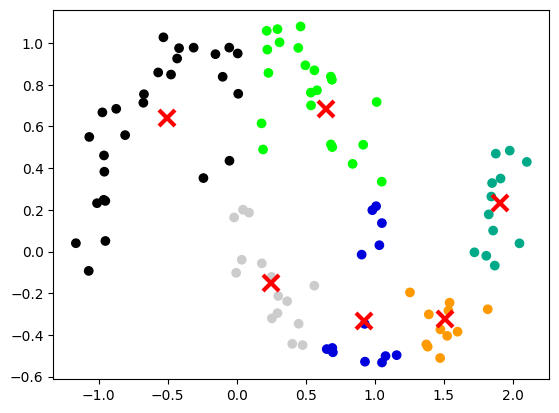

In [13]:
clust.max_iter = 2
clust.fit(X)

fig, axes = plt.subplots()
axes.scatter(X[:,0], X[:,1], c=clust.predict(X));
axes.plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3);

or just let it run for a large number of iterations, so it converges:

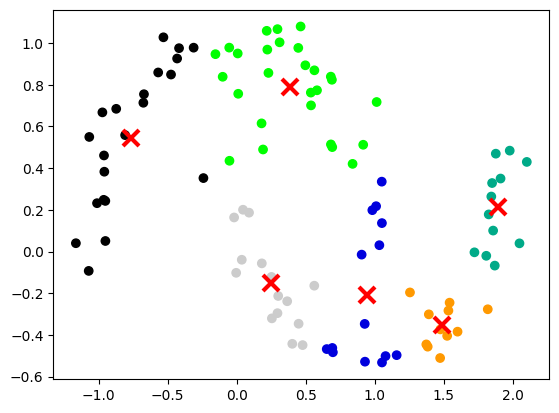

In [14]:
clust.max_iter = 500
clust.fit(X)

fig, axes = plt.subplots()
axes.scatter(X[:,0], X[:,1], c=clust.predict(X));
axes.plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3);

If we initialize differently, we will find different local optima:

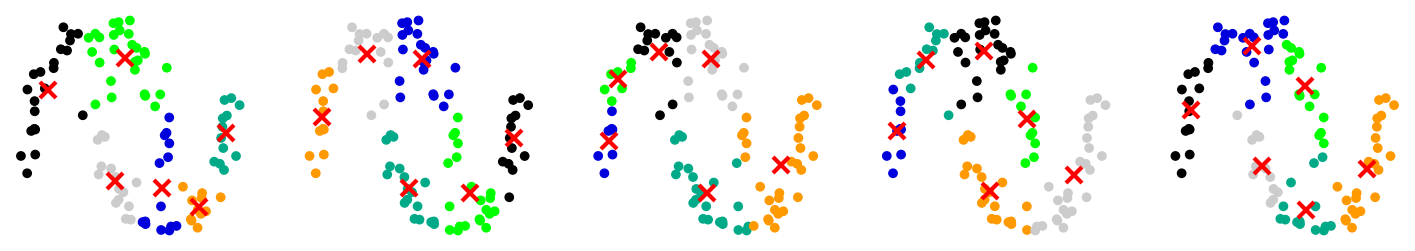

In [15]:
fig, axes = plt.subplots(1,5, figsize=(18,3))

for i in range(5):
    clust = KMeans(n_clusters=6, init='random', n_init=1, random_state=seed+i)
    clust.fit(X)
    axes[i].scatter(X[:,0], X[:,1], c=clust.predict(X));
    axes[i].plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3);
    axes[i].axis('off')

We can score our clustering using the distortion, or distance from each point to its closest center:

-11.479493412406578
-9.65145392315807
-13.651916218676925
-11.994093850473442
-11.463753682326022



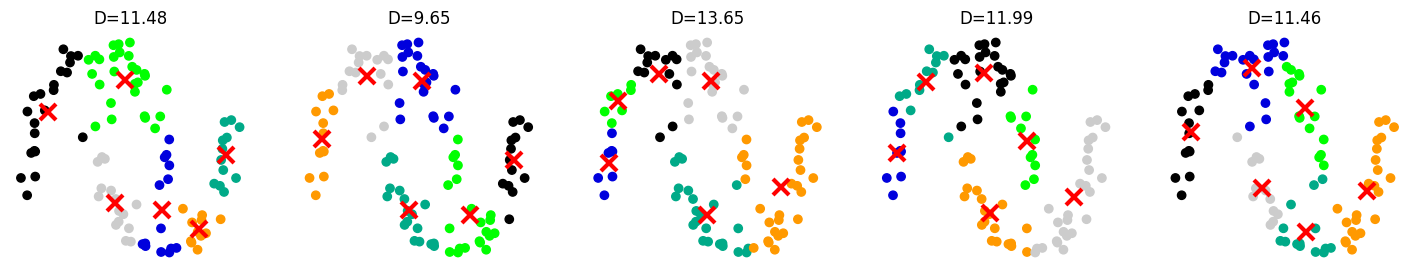

In [16]:
fig, axes = plt.subplots(1,5, figsize=(18,3))

for i in range(5):
    clust = KMeans(n_clusters=6, init='random', n_init=1, random_state=seed+i)
    clust.fit(X)
    axes[i].scatter(X[:,0], X[:,1], c=clust.predict(X));
    axes[i].plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3);
    axes[i].set_title(f'D={np.round(clust.inertia_,2)}')
    print(clust.score(X))  # "Score" is the negative of the distortion (so larger is better)
    axes[i].axis('off')

print()

A smarter initialization strategy is ``k-means++``, which randomly initializes using distance to the already-selected cluster centers to ensure diversity of the initial centers.  This often (but not always) finds a better clustering in fewer initializations:

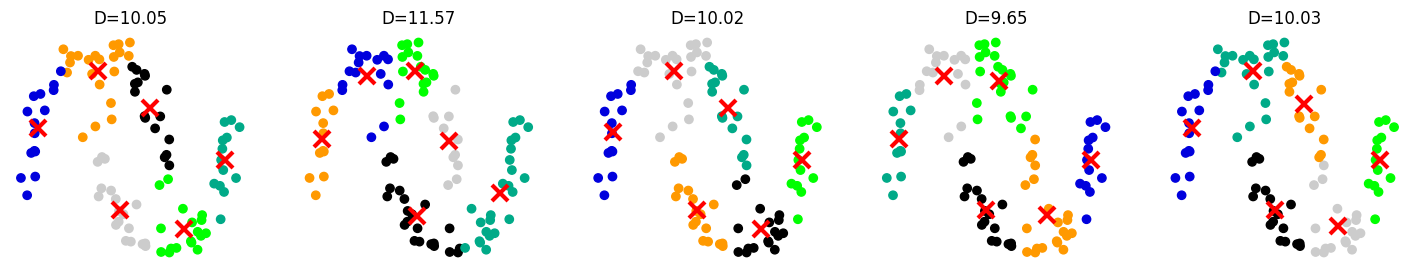

In [17]:
fig, axes = plt.subplots(1,5, figsize=(18,3))

for i in range(5):
    clust = KMeans(n_clusters=6, init='k-means++', n_init=1, random_state=seed+i)
    clust.fit(X)
    axes[i].scatter(X[:,0], X[:,1], c=clust.predict(X));
    axes[i].plot(clust.cluster_centers_[:,0],clust.cluster_centers_[:,1],'rx',ms=12,mew=3);
    axes[i].set_title(f'D={np.round(clust.inertia_,2)}')
    axes[i].axis('off')

# Other Clustering Methods
### Gaussian Mixture Models

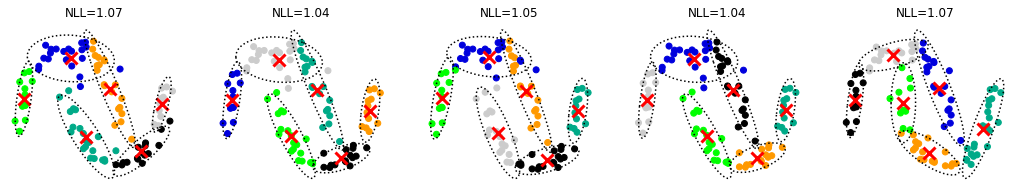

In [24]:
from sklearn.mixture import GaussianMixture

# For plotting the covariance circles for each Gaussian:
from scipy.linalg import sqrtm
th = np.linspace(-np.pi,np.pi,50); th = np.vstack((np.cos(th),np.sin(th))).T

fig, axes = plt.subplots(1,5, figsize=(18,3))

for i in range(5):
    clust = GaussianMixture(n_components=6, init_params='k-means++', random_state=seed+i)
    clust.fit(X)
    axes[i].scatter(X[:,0], X[:,1], c=clust.predict(X));
    axes[i].plot(clust.means_[:,0],clust.means_[:,1],'rx',ms=12,mew=3);
    for c in range(len(clust.means_)):
        circle = 2*th @ sqrtm(clust.covariances_[c,:,:]) + clust.means_[c:c+1,:]
        axes[i].plot(circle[:,0],circle[:,1],'k:')        
    axes[i].set_title(f'NLL={-np.round(clust.score(X),2)}')
    axes[i].axis('off')

### Agglomerative Clustering / Linkage

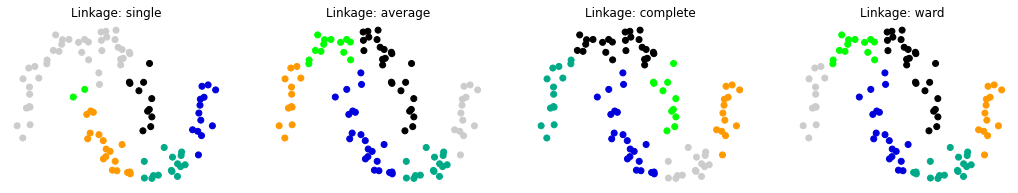

In [28]:
from sklearn.cluster import AgglomerativeClustering

fig, axes = plt.subplots(1,4, figsize=(18,3))

for i,link in enumerate(['single','average','complete','ward']):
    clust = AgglomerativeClustering(n_clusters=6,linkage=link)
    z = clust.fit_predict(X)
    axes[i].scatter(X[:,0], X[:,1], c=z);
    axes[i].set_title(f'Linkage: {link}')
    axes[i].axis('off')

----

# PCA on Text Data: "Latent Semantic Analysis (LSA)"

Here we have some of the text data from lecture, which we'll process using a bag-of-words representation followed by PCA.

This example is from: Landauer et al. (1998), "An Introduction to Latent Semantic Analysis".  Discourse Processes 25, 259-284.

In [20]:
plt.set_cmap('seismic');   # better colormap for this example

# The documents themselves:
docs    = ['Human machine interface for ABC computer applications',
           'A survey of user opinion of computer system response time',
           'The EPS user interface management system',
           'System and human system engineering testing of EPS',
           'Relation of user perceived response time to error measurement',
           'The generation of random, binary, ordered trees',
           'The intersection graph of paths in trees',
           'Graph minors IV: Widths of trees and well-quasi-ordering',
           'Graph minors: A survey']

# Normally, we would remove stop words, etc;
# here we'll just use a pre-constructed "interesting word" list
vocab_list = ['human','interface','computer','user','system','response','time',
         'EPS','survey','trees','graph','minors']

vocab = {w:i for i,w in enumerate(vocab_list)}
words = {i:w for i,w in enumerate(vocab_list)}
print(vocab)

{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'system': 4, 'response': 5, 'time': 6, 'EPS': 7, 'survey': 8, 'trees': 9, 'graph': 10, 'minors': 11}


<Figure size 640x480 with 0 Axes>

In [21]:
stopwords = 'the and was for that you with have are this from can which has were don'.split(' ')
# if exist stopwords.txt: load & append to stopwords
def filter_text(text):
    import re
    words = re.sub(r'[^\w ]',' ',text)
    words = map(lambda w: w.lower(), words.split(' '))
    words = filter(lambda w: w not in stopwords and len(w)>2, words)
    return list(words)

print(filter_text('This will filter out all the unwanted words, eh?'))

['will', 'filter', 'out', 'all', 'unwanted', 'words']


In [22]:
w = np.array([vocab[j] for i,txt in enumerate(docs) for j in filter_text(txt) if j in vocab ],dtype=int)
d = np.array([i for i,txt in enumerate(docs) for j in filter_text(txt) if j in vocab ],dtype=int)
D = max(d)+1
W = max(w)+1
N = len(d)

A typical representation consists of a list of the tokens in the data set, indicating which word appeared and which document it came from:

In [24]:
print("w: ",w)
print("d: ",d)

w:  [ 0  1  2  8  3  2  4  5  6  3  1  4  4  0  4  3  5  6  9 10  9 10 11  9
 10 11  8]
d:  [0 0 0 1 1 1 1 1 1 2 2 2 3 3 3 4 4 4 5 6 6 7 7 7 8 8 8]


Implicitly, this represents a data matrix "X", with X[d,w] indicating the count of the times word "w" appeared in document "d".  However, this matrix is very large and very sparse (mostly zeros).

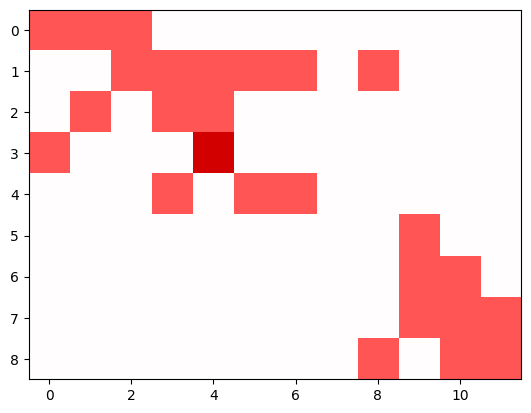

In [26]:
X = np.zeros( (max(d)+1,max(w)+1) );
for dd,ww in zip(d,w): X[dd,ww] += 1;
#X /= X.sum(axis=1,keepdims=True)
plt.imshow(X,vmin=-3,vmax=3);

We can look at the similarity of the data under a linear kernel, i.e., the dot-product similarity in the bag-of-words space:

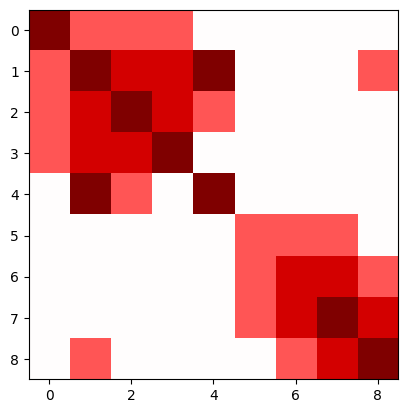

In [27]:
plt.imshow(X.dot(X.T),vmin=-3,vmax=3);

Taking the first two principle componenets of the data set:

[3.21150843 2.52551584 2.19932134 1.61105025 1.49104814 1.22387351
 0.84509128 0.559977   0.35586752]


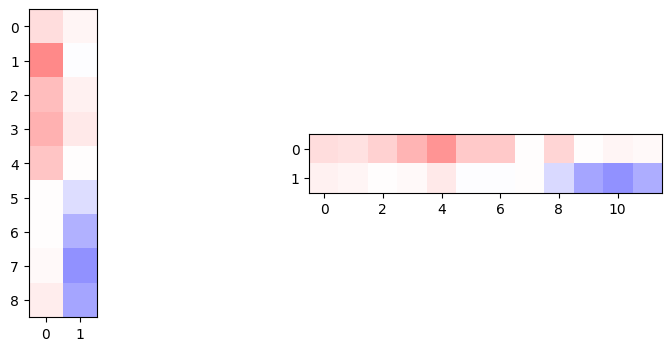

In [31]:
import scipy.linalg

U,S,V = scipy.linalg.svd(X,False)            # Take the SVD!

W = U.dot(np.diag(S))                      # often useful to combine U & S

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(U[:,:2],vmin=-3,vmax=3);
plt.subplot(1,2,2); plt.imshow(V[:2,:],vmin=-3,vmax=3);

print(S)


we see that we have two "topics" forming, one of which consists of positive counts for the first set of words (human, interaction, etc.; words 0-6) and has positive coefficients in the first five documents (about HCI).  The second topic (principle component) has negative counts for the graph theory words (words 8-11), and using negative coefficients in the last four documents gives a reconstruction of positive counts for these words in the math titles.

We can view this as providing a low-rank approximation to the original data set X:

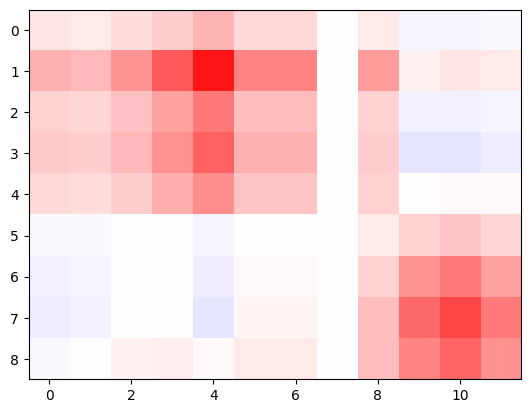

In [32]:
Xhat = U[:,:2].dot(np.diag(S[:2])).dot(V[:2,:])
plt.imshow(Xhat,vmin=-3,vmax=3);

in which we can still see the original structure, i.e., that words 0-6 tend to appear in titles 0-4, and words 8-10 tend to appear in titles 5-8.

Visualizing the (linear kernel) similarity between titles in this lower-dimensional space actually gives a better sense of similarity:

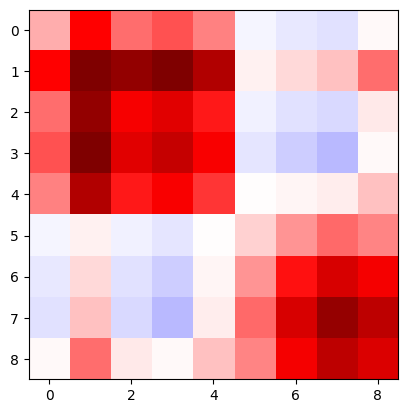

In [33]:
plt.imshow(Xhat.dot(Xhat.T),vmin=-3,vmax=3);

since now we see that documents 3 and 4 are now measuring as similar to one another, even though they have less direct overlap in their word choices; the model has figured out that these words form groups corresponding to concepts, and that the presence of some of those words indicates the presence of the concept itself, and is thus similar to documents that have different word sets corresponding to the same concept.